In [1]:
# Import packages
import pandas as pd
import numpy as np
from numbers import Number
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
# View directory
!ls

AviationData.csv            data_cleaning_lillian.ipynb
README.md                   data_cleaning_maddie.ipynb
USState_Codes.csv           data_cleaning_raj.ipynb


In [3]:
# Import AviationData file
aviation = pd.read_csv('AviationData.csv', encoding='ISO-8859-1', parse_dates=['Event.Date', 'Publication.Date'])

In [4]:
# Import USState_Codes file
us_state_codes = pd.read_csv('USState_Codes.csv')
us_state_codes.head()

,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [5]:
# Explore data
aviation.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaT
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,1996-09-19
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.9222,-81.8781,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,2007-02-26
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,2000-12-09
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,1980-04-16


In [6]:
aviation.tail()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
88884,20221227106491,Accident,ERA23LA093,2022-12-26,"Annapolis, MD",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,2022-12-29
88885,20221227106494,Accident,ERA23LA095,2022-12-26,"Hampton, NH",United States,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaT
88886,20221227106497,Accident,WPR23LA075,2022-12-26,"Payson, AZ",United States,341525N,1112021W,PAN,PAYSON,...,Personal,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,2022-12-27
88887,20221227106498,Accident,WPR23LA076,2022-12-26,"Morgan, UT",United States,NaN,NaN,NaN,NaN,...,Personal,MC CESSNA 210N LLC,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaT
88888,20221230106513,Accident,ERA23LA097,2022-12-29,"Athens, GA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN,2022-12-30


In [7]:
aviation.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,82805.000000,77488.000000,76379.000000,76956.000000,82977.000000
mean,1.146585,0.647855,0.279881,0.357061,5.325440
std,0.446510,5.485960,1.544084,2.235625,27.913634
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


In [8]:
aviation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                88889 non-null  object        
 1   Investigation.Type      88889 non-null  object        
 2   Accident.Number         88889 non-null  object        
 3   Event.Date              88889 non-null  datetime64[ns]
 4   Location                88837 non-null  object        
 5   Country                 88663 non-null  object        
 6   Latitude                34382 non-null  object        
 7   Longitude               34373 non-null  object        
 8   Airport.Code            50249 non-null  object        
 9   Airport.Name            52790 non-null  object        
 10  Injury.Severity         87889 non-null  object        
 11  Aircraft.damage         85695 non-null  object        
 12  Aircraft.Category       32287 non-null  object

In [9]:
aviation.isna().sum()

Event.Id                      0
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                     52
Country                     226
Latitude                  54507
Longitude                 54516
Airport.Code              38640
Airport.Name              36099
Injury.Severity            1000
Aircraft.damage            3194
Aircraft.Category         56602
Registration.Number        1317
Make                         63
Model                        92
Amateur.Built               102
Number.of.Engines          6084
Engine.Type                7077
FAR.Description           56866
Schedule                  76307
Purpose.of.flight          6192
Air.carrier               72241
Total.Fatal.Injuries      11401
Total.Serious.Injuries    12510
Total.Minor.Injuries      11933
Total.Uninjured            5912
Weather.Condition          4492
Broad.phase.of.flight     27165
Report.Status              6381
Publication.Date          13771
dtype: i

In [10]:
# Found 938 duplicate Event.Ids
aviation.duplicated(subset='Event.Id').value_counts()

False    87951
True       938
dtype: int64

In [11]:
# Drop duplicate Event.Ids
aviation.drop_duplicates(subset='Event.Id', inplace=True)

In [12]:
"""
Aircraft accident means an occurrence associated with the operation of an aircraft which takes place between the time any person boards the aircraft with the intention of flight and all such persons have disembarked, and in which any person suffers death or serious injury, or in which the aircraft receives substantial damage

Incident means an occurrence other than an accident, associated with the operation of an aircraft, which affects 

Source: https://www.govinfo.gov/content/pkg/CFR-2011-title49-vol7/pdf/CFR-2011-title49-vol7-sec830-2.pdf
"""

aviation['Investigation.Type'].value_counts()

Accident    84190
Incident     3761
Name: Investigation.Type, dtype: int64

In [13]:
aviation['Accident.Number'].value_counts()

ATL82DA151    1
ANC01TA076    1
ERA17WA178    1
WPR14CA352    1
FTW00LA011    1
             ..
CEN19LA064    1
IAD05LA010    1
WPR18LA105    1
BFO91DIA01    1
LAX03LA132    1
Name: Accident.Number, Length: 87951, dtype: int64

In [14]:
aviation.duplicated(subset='Accident.Number').value_counts()

False    87951
dtype: int64

In [15]:
# Split out the event date into year, month and day using DateTime methods

aviation['Event.Year'] = aviation['Event.Date'].dt.year
aviation['Event.Month'] = aviation['Event.Date'].dt.month
aviation['Event.Day'] = aviation['Event.Date'].dt.day

In [16]:
# Create new dataframe of incidents by year
incidents_by_year = aviation['Event.Year'].value_counts()
incidents_by_year = incidents_by_year.sort_index()
incidents_by_year

1948       1
1962       1
1974       1
1977       1
1979       2
1981       1
1982    3547
1983    3513
1984    3406
1985    3053
1986    2832
1987    2773
1988    2685
1989    2502
1990    2480
1991    2420
1992    2328
1993    2285
1994    2229
1995    2278
1996    2150
1997    2121
1998    2196
1999    2174
2000    2183
2001    2032
2002    2001
2003    2063
2004    1932
2005    2001
2006    1826
2007    1984
2008    1893
2009    1783
2010    1786
2011    1850
2012    1835
2013    1561
2014    1535
2015    1582
2016    1664
2017    1638
2018    1681
2019    1624
2020    1392
2021    1545
2022    1581
Name: Event.Year, dtype: int64

Text(0.5, 0, 'Years')

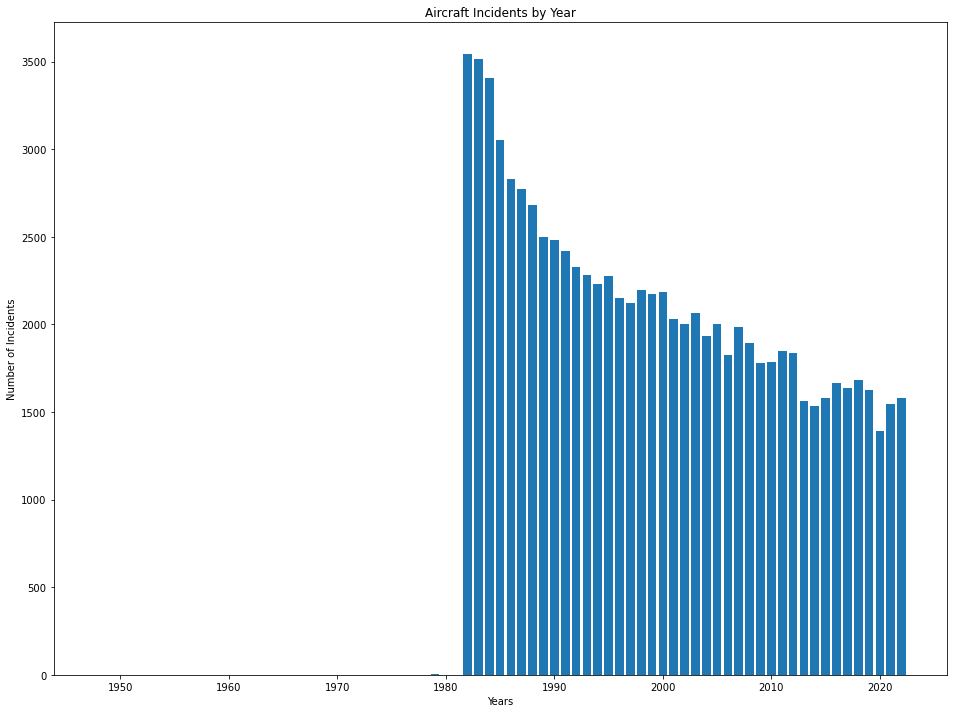

In [17]:
# Graph incidents by year
years = list(incidents_by_year.index)
incidents = list(incidents_by_year.values)

fig, ax = plt.subplots(figsize=(16, 12))

ax.bar(years, incidents)
ax.set_title("Aircraft Incidents by Year")
ax.set_ylabel("Number of Incidents")
ax.set_xlabel("Years")


In [18]:
aviation.loc[(aviation['Country'] != 'United States')]

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Event.Year,Event.Month,Event.Day
36,20020917X02410,Accident,MIA82FKA05,1982-01-04,SAINT CROIX,NaN,NaN,NaN,STX,ALEXANDER HAMILTON,...,0.0,1.0,0.0,VMC,Taxi,Probable Cause,1983-04-01,1982,1,4
237,20020917X02008,Accident,FTW82DA055,1982-02-04,GULF OF MEXICO,GULF OF MEXICO,NaN,NaN,SS87,SHIP SHOAL 87,...,0.0,0.0,1.0,VMC,Takeoff,Probable Cause,1983-04-02,1982,2,4
333,20020917X02346,Accident,MIA82DA047,1982-02-15,SAN JUAN,Puerto Rico,NaN,NaN,SJU,SAN JUAN INTL,...,0.0,0.0,1.0,VMC,Approach,Probable Cause,1983-02-15,1982,2,15
402,20020917X02367,Accident,MIA82DA077,1982-02-23,ATLANTIC OCEAN,ATLANTIC OCEAN,NaN,NaN,NaN,NaN,...,2.0,0.0,0.0,VMC,Cruise,Probable Cause,1983-02-23,1982,2,23
463,20020917X02025,Accident,FTW82DA075,1982-03-02,HIGH ISLAND BLK,HIGH ISLAND,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,VMC,Approach,Probable Cause,1983-02-03,1982,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88850,20221219106471,Accident,GAA23WA043,2022-12-05,"PONTA GROSSA,",Brazil,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,NaN,NaN,NaN,2022-12-20,2022,12,5
88851,20221222106485,Incident,DCA23WA100,2022-12-05,"Bangkok,",Thailand,NaN,NaN,NaN,NaN,...,0.0,0.0,102.0,NaN,NaN,NaN,2022-12-22,2022,12,5
88863,20221213106449,Accident,GAA22WA311,2022-12-11,"Kildare,",Ireland,NaN,NaN,EIKH,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaT,2022,12,11
88872,20221214106459,Accident,GAA23WA042,2022-12-14,"Happy Valley-Goose Bay, OF",Canada,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,NaN,NaN,NaN,2022-12-20,2022,12,14


In [19]:
# Parse records for State column from records in Location column
aviation['State'] = aviation['Location'].str.split(", ").str[1]

In [20]:
# Update state records for non-US locations
aviation.loc[aviation['Country'] != 'United States', 'State'] = 'non-US'

In [21]:
# Review State records
aviation['State'].value_counts()

CA              8700
non-US          6596
TX              5839
FL              5732
AK              5625
                ... 
LA,                1
MANU'A             1
MG                 1
HONOLULU           1
San Juan Is.       1
Name: State, Length: 72, dtype: int64

In [22]:
# Review State records that need to be cleaned
aviation['State'].value_counts(sort=True, ascending=True)[:25]

San Juan Is.      1
HONOLULU          1
MG                1
MANU'A            1
LA,               1
Oahu              1
CB                1
NYC               1
Maui              2
UN                3
MAUI              4
OAHU              4
KAUAI             5
VI                6
GU                8
PO               14
OF               15
AO               17
DC               40
GM               44
DE              112
PR              113
RI              155
VT              238
NH              366
Name: State, dtype: int64

In [23]:
# 1 record that is AO
aviation.loc[(aviation['Location'] == 'Atlantic Ocean')]

# 1 record that is AS
aviation.loc[(aviation['State'] == "MANU'A")]

# 1 record that is CA
aviation.loc[(aviation['State'] == 'LA,')]

# 2 records that are Unknown and 1 that is GM
aviation.loc[(aviation['State'] == 'UN')]

# 16 records that are HI
aviation.loc[(aviation['State'] == 'MAUI') | (aviation['State'] == 'Maui') | (aviation['State'] == 'OAHU') | (aviation['State'] == 'KAUAI') | (aviation['State'] == 'HONOLULU')]

# records that are non-US
aviation.loc[(aviation['State'] == 'MG') | (aviation['State'] == 'OF')]

# 1 record that is NY
aviation.loc[(aviation['State'] == 'NYC')]

# 1 record that is PR
aviation.loc[(aviation['State'] == 'San Juan Is.')]

# 1 record that is VI
aviation.loc[(aviation['State'] == 'CB')]

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Event.Year,Event.Month,Event.Day,State
85869,20210216102634,Accident,ERA21FA130,2021-02-15,"St Thomas, CB",United States,182116N,0065140W,NaN,NaN,...,0.0,0.0,VMC,NaN,NaN,2021-02-26,2021,2,15,CB


In [24]:
# Change record to AO
aviation.loc[(aviation['Location'] == 'Atlantic Ocean, OF'), 'State'] = 'AO'

# Change record to AS
aviation.loc[(aviation['State'] == "MANU'A"), 'State'] = 'AS'

# Change record to CA
aviation.loc[(aviation['State'] == 'LA,'), 'State'] = 'CA'

# Change record to GM
aviation.loc[(aviation['Location'] == 'GULF OF MEXICO, UN'), 'State'] = 'GM'

# Change records to HI
aviation.loc[(aviation['State'] == 'MAUI') | (aviation['State'] == 'Maui') | (aviation['State'] == 'OAHU') | (aviation['State'] == 'Oahu') | (aviation['State'] == 'KAUAI') | (aviation['State'] == 'HONOLULU'), 'State'] = 'HI'

# # Change record to non-US
aviation.loc[((aviation['State'] == 'MG') | (aviation['State'] == 'OF')) & (aviation['Location'] != 'Atlantic Ocean, OF'), 'State'] = 'non-US'

# Change record to NY
aviation.loc[(aviation['State'] == 'NYC'), 'State'] = 'NY'

# Change record to PR
aviation.loc[(aviation['State'] == 'San Juan Is.'), 'State'] = 'PR'

# Change record to Unknown
aviation.loc[(aviation['Location'] == 'Missing, UN') | (aviation['Location'] == 'Oceanic, UN'), 'State'] = 'Unknown'

# Change record to VI
aviation.loc[(aviation['State'] == 'CB'), 'State'] = 'VI'

In [25]:
# Verify all State records are cleaned
aviation['State'].value_counts()

CA         8701
non-US     6611
TX         5839
FL         5732
AK         5625
AZ         2804
CO         2702
WA         2578
IL         2022
MI         2018
GA         2006
NY         1875
OH         1804
PA         1776
OR         1765
NC         1649
MO         1554
WI         1531
AR         1510
MN         1447
ID         1434
NM         1350
UT         1331
IN         1311
VA         1267
OK         1224
NV         1216
LA         1204
AL         1143
NJ         1141
KS         1098
TN         1096
MT         1047
SC          970
MA          953
IA          814
MS          810
MD          807
WY          733
NE          719
KY          650
ND          559
ME          502
CT          500
HI          492
SD          444
WV          394
NH          366
VT          238
RI          155
PR          114
DE          112
GM           45
DC           40
AO           18
PO           14
GU            8
VI            7
Unknown       2
AS            1
Name: State, dtype: int64

In [26]:
# Verify only Unknown and/or non-US state locations appear in cleaned State records
invalid_state_locations = []

for state in list(aviation['State'].value_counts().index):
  if state not in list(us_state_codes['Abbreviation']):
    invalid_state_locations.append(state)

invalid_state_locations

['non-US', 'Unknown']

In [27]:
aviation['Country'].isna().value_counts()

False    87729
True       222
Name: Country, dtype: int64

In [28]:
blank_countries = set(aviation.loc[(aviation['Country'].isna())]['Location'])
blank_countries
len(blank_countries) # 0 if years are 2009+, otherwise blank countries need to be scrubbed

145

In [29]:
# Fix Country for US locations with blank Country records

valid_US_locations = [
 'CHARLOTTE AMALI',
 'CHRISTIANSTED',
'FAJARDO',
 'GUAM',
'GUAYAMA',
'Guam',
'NEAR SAN JUAN',
 'NEAR ST. CROIX',
 'NO.ATLANTIC OC',
 'SAINT CROIX',
 'ST CROIX',
 'ST THOMAS',
 'ST. CROIX',
 'ST. THOMAS',
 'ST.THOMAS',
 'STAKE ISLAND',
 'VIEQUES']

aviation.loc[(aviation['Location'].isin(valid_US_locations)), 'Country'] = 'United States'

In [30]:
# Fix State for US locations with blank Country records

valid_VI_locations = [
'CHARLOTTE AMALI',
 'CHRISTIANSTED',
'NEAR ST. CROIX',
'SAINT CROIX',
 'ST CROIX',
 'ST THOMAS',
 'ST. CROIX',
 'ST. THOMAS',
'ST.THOMAS',
'VIEQUES']

valid_PR_locations = [
'FAJARDO',
'GUAYAMA',
'NEAR SAN JUAN']

valid_GM_locations = [
 'GUAM',
'Guam']

valid_AO_locations = [
'NO.ATLANTIC OC']

valid_MS_locations = [
'STAKE ISLAND']

aviation.loc[(aviation['Location'].isin(valid_VI_locations)), 'State'] = 'VI'
aviation.loc[(aviation['Location'].isin(valid_PR_locations)), 'State'] = 'PR'
aviation.loc[(aviation['Location'].isin(valid_GM_locations)), 'State'] = 'GM'
aviation.loc[(aviation['Location'].isin(valid_AO_locations)), 'State'] = 'SO'
aviation.loc[(aviation['Location'].isin(valid_MS_locations)), 'State'] = 'MS'



In [31]:
aviation['Amateur.Built'].value_counts()

No     79431
Yes     8420
Name: Amateur.Built, dtype: int64

In [32]:
# Remove amateur built planes
aviation = aviation[aviation['Amateur.Built'] == 'No']

In [33]:
# Drop irrelevant columns
aviation.drop(columns=['Accident.Number', 'Latitude', 'Longitude', 'Airport.Code', 'Airport.Name', 'Registration.Number', 'Amateur.Built', 'FAR.Description', 'Schedule', 'Publication.Date', 'Air.carrier'], inplace=True)

In [34]:
# Note: We no longer have records with format 'Fatal(#)' after dropping records with Event.Year prior to 2009
aviation['Injury.Severity'].value_counts()

Non-Fatal     60796
Fatal(1)       4872
Fatal          4554
Fatal(2)       3236
Incident       2046
              ...  
Fatal(45)         1
Fatal(124)        1
Fatal(174)        1
Fatal(143)        1
Fatal(110)        1
Name: Injury.Severity, Length: 106, dtype: int64

In [35]:
aviation['Aircraft.damage'].value_counts()

Substantial    57452
Destroyed      16205
Minor           2601
Unknown          116
Name: Aircraft.damage, dtype: int64

In [36]:
aviation['Aircraft.Category'].value_counts()

Airplane             24324
Helicopter            3290
Glider                 473
Balloon                229
Weight-Shift           139
Powered Parachute       83
Gyrocraft               32
Ultralight              18
Unknown                 11
WSFT                     9
Powered-Lift             5
Blimp                    4
UNK                      2
Rocket                   1
Name: Aircraft.Category, dtype: int64

In [37]:
# Filter only airplanes
aviation = aviation[aviation['Aircraft.Category'] == 'Airplane']

In [38]:
aviation['Make'].value_counts()

CESSNA                       4860
Cessna                       3549
PIPER                        2803
Piper                        1885
BOEING                       1027
                             ... 
BROWN MITCH                     1
SYMPHONY AIRCRAFT IND INC       1
COLONIAL                        1
Travel Air                      1
COSMOS PHASE II                 1
Name: Make, Length: 1381, dtype: int64

In [39]:
# Convert all rows in column 'Make' to title case strings for easier cleaning
aviation['Make'] = aviation.Make.astype(str).str.title()

In [40]:
# Convert all rows in column 'Make' to objects
aviation['Make'] = aviation['Make'].astype(object)

In [41]:
# Boeing is listed in several different formats in the data i.e 'The Boeing Company'. This code checks all rows in 'Make' for substring
# 'boeing' and changes it the value to standard 'boeing'

aviation['Make'].loc[aviation['Make'].str.contains('Boeing')] = 'Boeing'

In [42]:
def normalize_company_names(df, column_name, company_name):
    '''Takes in df dataframe, checks every value in column_name for substring company_name
        If substring company_name exists, the value of the row is overwritten to company_name.
        Then returns the new df dataframe'''
    df[column_name].loc[df[column_name].str.contains(company_name)] = company_name
    return df

In [43]:
# Check function by normalizing all companies with 'Piper'
normalize_company_names(aviation, 'Make', 'Piper')

,Event.Id,Investigation.Type,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,...,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Event.Year,Event.Month,Event.Day,State
5,20170710X52551,Accident,1979-09-17,"BOSTON, MA",United States,Non-Fatal,Substantial,Airplane,Mcdonnell Douglas,DC9,...,NaN,1.0,44.0,VMC,Climb,Probable Cause,1979,9,17,MA
7,20020909X01562,Accident,1982-01-01,"PULLMAN, WA",United States,Non-Fatal,Substantial,Airplane,Cessna,140,...,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,1982,1,1,WA
8,20020909X01561,Accident,1982-01-01,"EAST HANOVER, NJ",United States,Non-Fatal,Substantial,Airplane,Cessna,401B,...,0.0,0.0,2.0,IMC,Landing,Probable Cause,1982,1,1,NJ
12,20020917X02148,Accident,1982-01-02,"HOMER, LA",United States,Non-Fatal,Destroyed,Airplane,Bellanca,17-30A,...,0.0,1.0,0.0,IMC,Cruise,Probable Cause,1982,1,2,LA
13,20020917X02134,Accident,1982-01-02,"HEARNE, TX",United States,Fatal(1),Destroyed,Airplane,Cessna,R172K,...,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,1982,1,2,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88869,20221213106455,Accident,2022-12-13,"Lewistown, MT",United States,Non-Fatal,Substantial,Airplane,Piper,PA42,...,0.0,0.0,1.0,NaN,NaN,NaN,2022,12,13,MT
88873,20221215106463,Accident,2022-12-14,"San Juan, PR",United States,Non-Fatal,Substantial,Airplane,Cirrus Design Corp,SR22,...,0.0,0.0,1.0,VMC,NaN,NaN,2022,12,14,PR
88876,20221219106475,Accident,2022-12-15,"Wichita, KS",United States,Non-Fatal,Substantial,Airplane,Swearingen,SA226TC,...,0.0,0.0,1.0,NaN,NaN,NaN,2022,12,15,KS
88877,20221219106470,Accident,2022-12-16,"Brooksville, FL",United States,Minor,Substantial,Airplane,Cessna,R172K,...,1.0,0.0,0.0,VMC,NaN,NaN,2022,12,16,FL


In [44]:
# Normalize the company names of the top airline manufacturers
normalize_company_names(aviation, 'Make', 'Boeing')
normalize_company_names(aviation, 'Make', 'Airbus')
normalize_company_names(aviation, 'Make', 'Cessna')
normalize_company_names(aviation, 'Make', 'Beech')
normalize_company_names(aviation, 'Make', 'Cirrus')

,Event.Id,Investigation.Type,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,...,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Event.Year,Event.Month,Event.Day,State
5,20170710X52551,Accident,1979-09-17,"BOSTON, MA",United States,Non-Fatal,Substantial,Airplane,Mcdonnell Douglas,DC9,...,NaN,1.0,44.0,VMC,Climb,Probable Cause,1979,9,17,MA
7,20020909X01562,Accident,1982-01-01,"PULLMAN, WA",United States,Non-Fatal,Substantial,Airplane,Cessna,140,...,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,1982,1,1,WA
8,20020909X01561,Accident,1982-01-01,"EAST HANOVER, NJ",United States,Non-Fatal,Substantial,Airplane,Cessna,401B,...,0.0,0.0,2.0,IMC,Landing,Probable Cause,1982,1,1,NJ
12,20020917X02148,Accident,1982-01-02,"HOMER, LA",United States,Non-Fatal,Destroyed,Airplane,Bellanca,17-30A,...,0.0,1.0,0.0,IMC,Cruise,Probable Cause,1982,1,2,LA
13,20020917X02134,Accident,1982-01-02,"HEARNE, TX",United States,Fatal(1),Destroyed,Airplane,Cessna,R172K,...,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,1982,1,2,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88869,20221213106455,Accident,2022-12-13,"Lewistown, MT",United States,Non-Fatal,Substantial,Airplane,Piper,PA42,...,0.0,0.0,1.0,NaN,NaN,NaN,2022,12,13,MT
88873,20221215106463,Accident,2022-12-14,"San Juan, PR",United States,Non-Fatal,Substantial,Airplane,Cirrus,SR22,...,0.0,0.0,1.0,VMC,NaN,NaN,2022,12,14,PR
88876,20221219106475,Accident,2022-12-15,"Wichita, KS",United States,Non-Fatal,Substantial,Airplane,Swearingen,SA226TC,...,0.0,0.0,1.0,NaN,NaN,NaN,2022,12,15,KS
88877,20221219106470,Accident,2022-12-16,"Brooksville, FL",United States,Minor,Substantial,Airplane,Cessna,R172K,...,1.0,0.0,0.0,VMC,NaN,NaN,2022,12,16,FL


In [45]:
# Look at the top 20 companies by number of incidents
aviation['Make'].value_counts()[0:20]

Cessna               8467
Piper                4757
Beech                1756
Boeing               1319
Mooney                416
Cirrus                401
Airbus                281
Bellanca              281
Grumman               245
Maule                 232
Aeronca               227
Air Tractor           223
Air Tractor Inc       219
Champion              169
Luscombe              163
Embraer               154
Stinson               145
North American        118
Mcdonnell Douglas     111
Taylorcraft           109
Name: Make, dtype: int64

In [46]:
aviation['Model'].value_counts()

172            866
152            444
737            401
182            343
172N           312
              ... 
Clipper 912      1
01               1
SKY RAIDER       1
ULTRA PUP        1
Pitts S-2B       1
Name: Model, Length: 3768, dtype: int64

In [47]:
aviation['Model'].isna().value_counts()

False    24306
True        18
Name: Model, dtype: int64

In [48]:
aviation['Number.of.Engines'].value_counts()

1.0    18168
2.0     3448
4.0       99
3.0       58
0.0        9
6.0        1
8.0        1
Name: Number.of.Engines, dtype: int64

In [49]:
aviation['Number.of.Engines'].isna().value_counts()

False    21784
True      2540
Name: Number.of.Engines, dtype: int64

In [50]:
aviation['Engine.Type'].value_counts()

Reciprocating      17799
Turbo Prop          1324
Turbo Fan            955
Turbo Jet            150
Unknown              133
Geared Turbofan       12
Turbo Shaft           10
Electric               5
UNK                    1
Name: Engine.Type, dtype: int64

In [51]:
aviation['Engine.Type'].isna().value_counts()

False    20389
True      3935
Name: Engine.Type, dtype: int64

In [52]:
aviation['Purpose.of.flight'].value_counts()

Personal                     13314
Instructional                 3104
Aerial Application            1062
Unknown                        824
Business                       757
Positioning                    349
Aerial Observation             170
Skydiving                      165
Ferry                          163
Other Work Use                 154
Executive/corporate            147
Flight Test                    120
Banner Tow                      89
Public Aircraft - Federal       52
Air Race show                   48
Public Aircraft                 42
Glider Tow                      35
Public Aircraft - State         24
Firefighting                    17
Public Aircraft - Local         12
Air Race/show                    4
ASHO                             4
PUBS                             3
Air Drop                         3
External Load                    1
Name: Purpose.of.flight, dtype: int64

In [53]:
aviation['Total.Fatal.Injuries'].value_counts()

0.0      17174
1.0       2061
2.0       1288
3.0        406
4.0        301
         ...  
58.0         1
131.0        1
162.0        1
90.0         1
27.0         1
Name: Total.Fatal.Injuries, Length: 65, dtype: int64

In [54]:
aviation['Total.Fatal.Injuries'].isna().value_counts()

False    21576
True      2748
Name: Total.Fatal.Injuries, dtype: int64

In [55]:
aviation['Total.Minor.Injuries'].value_counts()

0.0      18671
1.0       2193
2.0        654
3.0        134
4.0         63
5.0         22
6.0         14
7.0         10
8.0          3
9.0          3
17.0         2
19.0         2
13.0         2
14.0         2
10.0         2
47.0         1
200.0        1
27.0         1
33.0         1
25.0         1
16.0         1
12.0         1
50.0         1
24.0         1
40.0         1
42.0         1
22.0         1
18.0         1
Name: Total.Minor.Injuries, dtype: int64

In [56]:
aviation['Total.Minor.Injuries'].isna().value_counts()

False    21790
True      2534
Name: Total.Minor.Injuries, dtype: int64

In [57]:
aviation['Total.Serious.Injuries'].value_counts()

0.0      18122
1.0       2176
2.0        835
3.0        171
4.0         96
5.0         23
6.0         17
7.0         11
8.0          8
9.0          8
10.0         7
11.0         5
14.0         2
12.0         2
26.0         2
21.0         2
25.0         2
41.0         1
137.0        1
125.0        1
28.0         1
53.0         1
34.0         1
19.0         1
88.0         1
63.0         1
22.0         1
20.0         1
33.0         1
161.0        1
35.0         1
67.0         1
44.0         1
27.0         1
13.0         1
47.0         1
Name: Total.Serious.Injuries, dtype: int64

In [58]:
aviation['Total.Serious.Injuries'].isna().value_counts()

False    21508
True      2816
Name: Total.Serious.Injuries, dtype: int64

In [59]:
aviation['Total.Uninjured'].value_counts()

0.0      8328
1.0      7205
2.0      4692
3.0      1130
4.0       677
         ... 
87.0        1
588.0       1
274.0       1
248.0       1
62.0        1
Name: Total.Uninjured, Length: 308, dtype: int64

In [60]:
aviation['Total.Uninjured'].isna().value_counts()

False    23615
True       709
Name: Total.Uninjured, dtype: int64

In [61]:
# Add total passengers column 
aviation['Total.Passengers'] = aviation['Total.Fatal.Injuries'] + aviation['Total.Minor.Injuries'] + aviation['Total.Serious.Injuries'] + aviation['Total.Uninjured']

In [62]:
aviation['Total.Passengers'].value_counts()

1.0      8844
2.0      6777
3.0      1754
4.0      1192
0.0       850
         ... 
348.0       1
69.0        1
229.0       1
311.0       1
263.0       1
Name: Total.Passengers, Length: 298, dtype: int64

In [63]:
# Add percent fatalities column
aviation['Percent.Fatalities'] = aviation['Total.Fatal.Injuries'] / aviation['Total.Passengers']

In [64]:
aviation['Percent.Fatalities'].value_counts()

0.000000    16324
1.000000     3403
0.500000      362
0.333333       92
0.666667       70
            ...  
0.875000        1
0.140187        1
0.888889        1
0.991150        1
0.777778        1
Name: Percent.Fatalities, Length: 62, dtype: int64

In [65]:
# Create a column for the percent of passengers killed or injured in accident 
aviation['Percent.Passengers.Harmed'] = (aviation['Total.Fatal.Injuries'] + aviation['Total.Minor.Injuries'] + aviation['Total.Serious.Injuries']) / aviation['Total.Passengers']

In [66]:
aviation['Percent.Passengers.Harmed'].value_counts()

0.000000    11772
1.000000     7478
0.500000      501
0.333333      123
0.666667       72
            ...  
0.010363        1
0.148649        1
0.029740        1
0.026144        1
0.669291        1
Name: Percent.Passengers.Harmed, Length: 269, dtype: int64

In [67]:
"""
VMC stands for “visual meteorological conditions”. VMC conditions describe the weather conditions and situations in which a pilot can sufficiently and safely maintain visuals of all other aircraft and the terrain around them. 
IMC is “instrument meteorological conditions”. MC conditions describe a situation in which visibility and the weather require the pilot to rely on their instruments, and thus conduct an IFR flight.
IFR stands for “instrument flight rules” and are utilized in situations where the weather or visibility is poor enough to warrant relying on the aircraft instruments only to maintain a safe flight. With both rule sets, the weather will decide what the pilot uses.
Source: https://www.aerospaceexchange.com/blog/what-do-vmc-and-imc-mean-to-the-pilot
"""

aviation['Weather.Condition'].value_counts()


VMC    19633
IMC     1358
Unk      215
UNK      148
Name: Weather.Condition, dtype: int64

In [68]:
aviation['Weather.Condition'].isna().value_counts()

False    21354
True      2970
Name: Weather.Condition, dtype: int64

In [69]:
aviation['Broad.phase.of.flight'].value_counts()
aviation['Broad.phase.of.flight'].describe()

count        5729
unique         12
top       Landing
freq         2069
Name: Broad.phase.of.flight, dtype: object

In [70]:
# Drop 'Broad.Phase.of.Flight' column as there were too many null values and there are no records from 2009 and beyond
aviation.drop(columns=['Broad.phase.of.flight'], inplace=True)

In [71]:
# TODO: LL: If time permits, we could gain additional insight by parsing records in the Report.Status column
aviation['Report.Status'].value_counts()

Probable Cause                                                                                                                                                                                                                          5730
Foreign                                                                                                                                                                                                                                  286
<br /><br />                                                                                                                                                                                                                             136
The pilot's failure to maintain directional control during the landing roll.                                                                                                                                                              50
A loss of engine power for undetermined reasons.    

In [72]:
aviation.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Event.Year,Event.Month,Event.Day,Total.Passengers,Percent.Fatalities,Percent.Passengers.Harmed
count,21784.000000,21576.000000,21508.000000,21790.000000,23615.000000,24324.000000,24324.000000,24324.00000,21307.000000,20457.000000,20457.000000
mean,1.177378,0.682286,0.304584,0.237357,6.921448,2009.512292,6.596900,15.77960,7.816351,0.183593,0.386485
std,0.426835,6.227703,2.225278,1.690989,32.845715,11.462663,3.065086,8.82918,32.826633,0.376876,0.476075
min,0.000000,0.000000,0.000000,0.000000,0.000000,1979.000000,1.000000,1.00000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,4.000000,8.00000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2012.000000,7.000000,16.00000,2.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000,2017.000000,9.000000,23.00000,2.000000,0.000000,1.000000
max,8.000000,295.000000,161.000000,200.000000,588.000000,2022.000000,12.000000,31.00000,576.000000,1.000000,1.000000


In [73]:
aviation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24324 entries, 5 to 88886
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Event.Id                   24324 non-null  object        
 1   Investigation.Type         24324 non-null  object        
 2   Event.Date                 24324 non-null  datetime64[ns]
 3   Location                   24318 non-null  object        
 4   Country                    24321 non-null  object        
 5   Injury.Severity            23518 non-null  object        
 6   Aircraft.damage            23063 non-null  object        
 7   Aircraft.Category          24324 non-null  object        
 8   Make                       24324 non-null  object        
 9   Model                      24306 non-null  object        
 10  Number.of.Engines          21784 non-null  float64       
 11  Engine.Type                20389 non-null  object        
 12  Purp

In [74]:
aviation.head()

,Event.Id,Investigation.Type,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,...,Total.Uninjured,Weather.Condition,Report.Status,Event.Year,Event.Month,Event.Day,State,Total.Passengers,Percent.Fatalities,Percent.Passengers.Harmed
5,20170710X52551,Accident,1979-09-17,"BOSTON, MA",United States,Non-Fatal,Substantial,Airplane,Mcdonnell Douglas,DC9,...,44.0,VMC,Probable Cause,1979,9,17,MA,NaN,NaN,NaN
7,20020909X01562,Accident,1982-01-01,"PULLMAN, WA",United States,Non-Fatal,Substantial,Airplane,Cessna,140,...,2.0,VMC,Probable Cause,1982,1,1,WA,2.0,0.0,0.0
8,20020909X01561,Accident,1982-01-01,"EAST HANOVER, NJ",United States,Non-Fatal,Substantial,Airplane,Cessna,401B,...,2.0,IMC,Probable Cause,1982,1,1,NJ,2.0,0.0,0.0
12,20020917X02148,Accident,1982-01-02,"HOMER, LA",United States,Non-Fatal,Destroyed,Airplane,Bellanca,17-30A,...,0.0,IMC,Probable Cause,1982,1,2,LA,1.0,0.0,1.0
13,20020917X02134,Accident,1982-01-02,"HEARNE, TX",United States,Fatal(1),Destroyed,Airplane,Cessna,R172K,...,0.0,IMC,Probable Cause,1982,1,2,TX,1.0,1.0,1.0


Text(0.5, 0, 'Years')

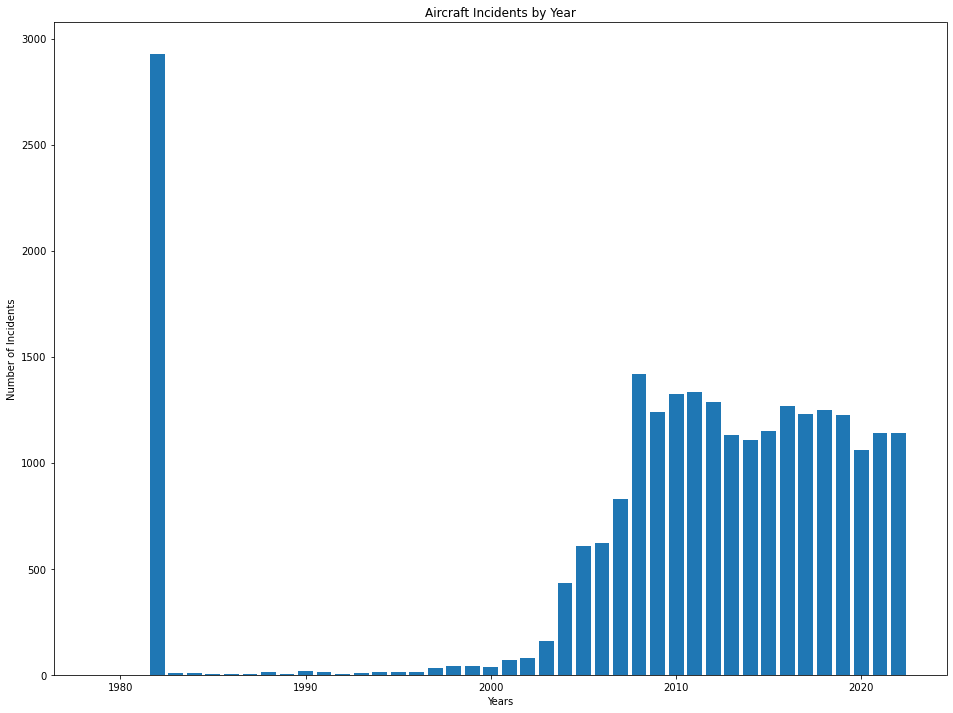

In [75]:
# Create new dataframe of incidents by year
incidents_by_year = aviation['Event.Year'].value_counts()
incidents_by_year = incidents_by_year.sort_index()
incidents_by_year

# Graph incidents by year
years = list(incidents_by_year.index)
incidents = list(incidents_by_year.values)

fig, ax = plt.subplots(figsize=(16, 12))

ax.bar(years, incidents)
ax.set_title("Aircraft Incidents by Year")
ax.set_ylabel("Number of Incidents")
ax.set_xlabel("Years")

In [76]:
aviation.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Event.Year,Event.Month,Event.Day,Total.Passengers,Percent.Fatalities,Percent.Passengers.Harmed
count,21784.000000,21576.000000,21508.000000,21790.000000,23615.000000,24324.000000,24324.000000,24324.00000,21307.000000,20457.000000,20457.000000
mean,1.177378,0.682286,0.304584,0.237357,6.921448,2009.512292,6.596900,15.77960,7.816351,0.183593,0.386485
std,0.426835,6.227703,2.225278,1.690989,32.845715,11.462663,3.065086,8.82918,32.826633,0.376876,0.476075
min,0.000000,0.000000,0.000000,0.000000,0.000000,1979.000000,1.000000,1.00000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,4.000000,8.00000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2012.000000,7.000000,16.00000,2.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000,2017.000000,9.000000,23.00000,2.000000,0.000000,1.000000
max,8.000000,295.000000,161.000000,200.000000,588.000000,2022.000000,12.000000,31.00000,576.000000,1.000000,1.000000


In [77]:
"""
Maddie: The number of airplane accidents by year rise until about 2009 then it remains relatively steady. I found an article that seems to back this up, I think it could be a good cut-off point!
https://www.cnbc.com/2019/02/13/colgan-air-crash-10-years-ago-reshaped-us-aviation-safety.html
"""

# Filter only data after 2009
aviation = aviation[aviation['Event.Year'] > 2009]

Text(0.5, 0, 'Years')

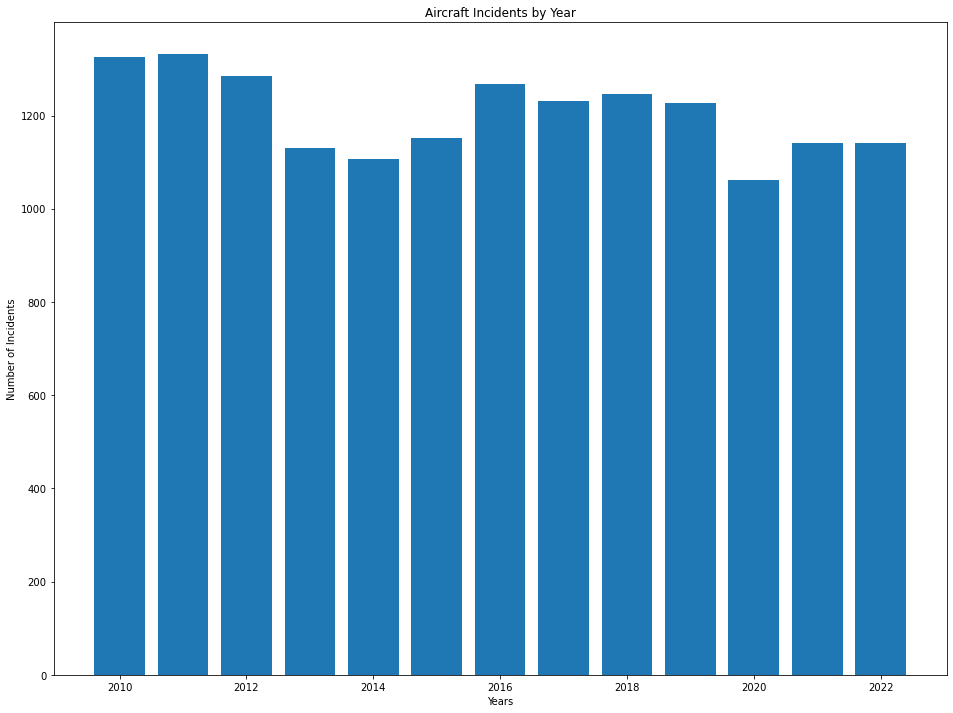

In [78]:
# Create new dataframe of incidents by year
incidents_by_year = aviation['Event.Year'].value_counts()
incidents_by_year = incidents_by_year.sort_index()
incidents_by_year

# Graph incidents by year
years = list(incidents_by_year.index)
incidents = list(incidents_by_year.values)

fig, ax = plt.subplots(figsize=(16, 12))

ax.bar(years, incidents)
ax.set_title("Aircraft Incidents by Year")
ax.set_ylabel("Number of Incidents")
ax.set_xlabel("Years")

In [79]:
aviation['Aircraft.Category'].value_counts()

Airplane    15648
Name: Aircraft.Category, dtype: int64

In [80]:
aviation['Aircraft.Category'].isna().value_counts()

False    15648
Name: Aircraft.Category, dtype: int64

In [81]:
aviation.drop(columns=['Aircraft.Category'], inplace=True)

In [82]:
aviation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15648 entries, 67590 to 88886
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Event.Id                   15648 non-null  object        
 1   Investigation.Type         15648 non-null  object        
 2   Event.Date                 15648 non-null  datetime64[ns]
 3   Location                   15648 non-null  object        
 4   Country                    15648 non-null  object        
 5   Injury.Severity            14881 non-null  object        
 6   Aircraft.damage            14632 non-null  object        
 7   Make                       15648 non-null  object        
 8   Model                      15641 non-null  object        
 9   Number.of.Engines          13490 non-null  float64       
 10  Engine.Type                12081 non-null  object        
 11  Purpose.of.flight          12552 non-null  object        
 12  

In [ ]:
aviation.to_csv('AviationDataClean.csv')